# Semiparametric latent position test - simulations

In [1]:
from pkg.utils import set_warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.inference import latent_position_test
from graspologic.simulations import rdpg
from joblib import Parallel, delayed
from pkg.io import savefig
from pkg.plot import set_theme
from tqdm import tqdm

foldername = "semipar_simulations"

set_theme()


def stashfig(name, **kwargs):
    savefig(name, foldername=foldername, **kwargs)

## Simulation setup
Here we sample from a simple RDPG model:
- $d = 1$
- $n = 64$
- $X_i \overset{iid}{\sim} Uniform(0.1, 0.9)$
- $Y_i \overset{iid}{\sim} Uniform(0.1, 0.9)$, independent of $X$
- If directed, $P = X Y^T$
- If undirected, $P = XX^T$
- $A_1, A_2 \overset{iid}{\sim} Bernoulli(P)$


Using this model, we run the following simulation under the null distribution:
- For $i$ in $n_{trials}$:
   - $A_1, A_2 \overset{iid}{\sim} Bernoulli(P)$
   - $p$ = $Semipar(A_1, A_2)$
   - Append p-value $p$ to the distribution of p-values under the null

For running semipar, I use $n_{bootstraps} = 200$. This is how many samples are used
to compute the null distribution to compute the p-value _for each trial_.

The above simulation is run using $ASE$ as the embedding method/test statistic.

In [2]:


def run_semipar_experiment(
    seed=None,
    directed=True,
    perturbation="none",
    n_verts=64,
    n_bootstraps=200,
    methods=["ase", "omnibus"],
):
    np.random.seed(seed)
    # sample latent positions
    X1 = np.random.uniform(0.1, 0.9, size=(n_verts, 1))
    if directed:
        Y1 = np.random.uniform(0.1, 0.9, size=(n_verts, 1))
    else:
        Y1 = None

    if perturbation == "none":
        X2 = X1
        Y2 = Y1

    # sample networks
    A1 = rdpg(X1, Y1, directed=directed, loops=False)
    A2 = rdpg(X2, Y2, directed=directed, loops=False)

    # run the tests
    rows = []
    for method in methods:
        lpt_result = latent_position_test(
            A1,
            A2,
            n_components=1,
            workers=1,
            embedding=method,
            n_bootstraps=n_bootstraps,
        )
        lpt_result = lpt_result._asdict()
        lpt_result["method"] = method
        lpt_result["perturbation"] = perturbation
        lpt_result["directed"] = directed
        lpt_result = {**lpt_result, **lpt_result["misc_stats"]}
        lpt_result.pop("misc_stats")
        lpt_result["null_distribution_1"] = list(lpt_result["null_distribution_1"])
        lpt_result["null_distribution_2"] = list(lpt_result["null_distribution_2"])
        rows.append(lpt_result)
    return rows


from pkg.io import get_out_dir
import ast

out_dir = get_out_dir(foldername=foldername)


def arrayize(string):
    return np.array(ast.literal_eval(string), dtype=float)


def saveload(name, results):
    if results is not None:
        results.to_csv(out_dir / name)
    results = pd.read_csv(
        out_dir / name,
        index_col=0,
        na_values="",
        keep_default_na=False,
        converters=dict(
            null_distribution_1=arrayize,
            null_distribution_2=arrayize,
        ),
    )
    return results


n_trials = 500
RECOMPUTE = False
if RECOMPUTE:
    rng = np.random.default_rng(8888)
    all_rows = []
    seeds = rng.integers(np.iinfo(np.int32).max, size=n_trials)
    all_rows += Parallel(n_jobs=-2, verbose=10)(
        delayed(run_semipar_experiment)(seed, False) for seed in seeds
    )
    all_rows += Parallel(n_jobs=-2, verbose=10)(
        delayed(run_semipar_experiment)(seed, True) for seed in seeds
    )
    results = []
    for rows in all_rows:
        results += rows
    results = pd.DataFrame(results)
else:
    results = None
results = saveload("null-simulation-results", results)

## Plot ECDFs of p-values under the null

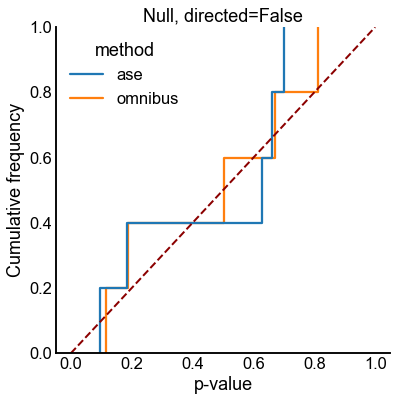

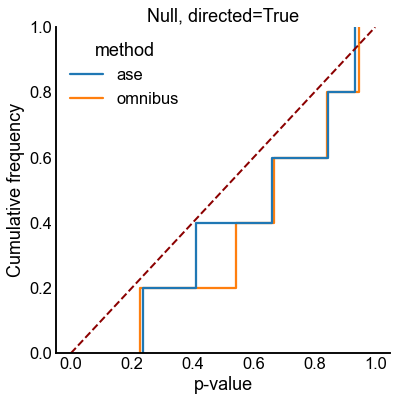

In [3]:
for directed in [False, True]:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.ecdfplot(
        data=results[(results["directed"] == directed)],
        x="p_value",
        hue="method",
    )
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=2, color="darkred")
    ax.set(
        title=f"Null, directed={directed}",
        xlabel="p-value",
        ylabel="Cumulative frequency",
    )
    stashfig(f"semipar-null-ecdf-directed={directed}")